# Libraries

In [ ]:
# %pip install diffusers lpips pytorch_fid gradio
# %pip install --upgrade ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 64.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 107.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.13.2
    Uninstalling tomlkit-0.13.2:
      Successfully uninstalled tomlkit-0.13.2
  Attempting uninstall: python-multipart
    Found existing installation: python-multipart 0.0.9
    Uninstalling python-multipart-0.0.9:
      Successfully uninstalled python-multipart-0.0.9
  Attempting uninstall: starlette
    Found existing installation: starl

In [ ]:
import transformers
transformers.utils.move_cache()

import os
import PIL
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

import torch
from pytorch_fid import fid_score
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from lpips import LPIPS
from sklearn.model_selection import train_test_split
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel
from transformers import BlipProcessor, BlipForConditionalGeneration
from accelerate import Accelerator

import warnings
warnings.filterwarnings("ignore")
os.environ["TORCH_HUB_NO_PROGRESS_BAR"] = "1"

0it [00:00, ?it/s]

# Load Pretrained Models

In [3]:
controlnet = ControlNetModel.from_pretrained(
    pretrained_model_name_or_path="nickpai/sdxl_light_caption_output",
    subfolder="checkpoint-30000/controlnet",
    torch_dtype=torch.float16
)

checkpoint-30000/controlnet/config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

In [4]:
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet, 
    torch_dtype=torch.float16
)

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
blip_processor = BlipProcessor.from_pretrained(
    "Salesforce/blip-image-captioning-large",
)
blip_generator = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-large",
    torch_dtype=torch.float16
)

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

In [6]:
accelerator = Accelerator(
    mixed_precision="fp16"
)

In [7]:
pipe.to(accelerator.device, dtype=torch.float16)
blip_generator.to(accelerator.device, dtype=torch.float16)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-23): 24 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (projection): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((1024,),

# Dataset

In [8]:
# for image captioning
def remove_unlikely_words(prompt: str) -> str:
    """
    Removes unlikely words from a prompt.

    Args:
        prompt: The text prompt to be cleaned.

    Returns:
        The cleaned prompt with unlikely words removed.
    """
    unlikely_words = []

    a1_list = [f'{i}s' for i in range(1900, 2000)]
    a2_list = [f'{i}' for i in range(1900, 2000)]
    a3_list = [f'year {i}' for i in range(1900, 2000)]
    a4_list = [f'circa {i}' for i in range(1900, 2000)]
    b1_list = [f"{year[0]} {year[1]} {year[2]} {year[3]} s" for year in a1_list]
    b2_list = [f"{year[0]} {year[1]} {year[2]} {year[3]}" for year in a1_list]
    b3_list = [f"year {year[0]} {year[1]} {year[2]} {year[3]}" for year in a1_list]
    b4_list = [f"circa {year[0]} {year[1]} {year[2]} {year[3]}" for year in a1_list]

    words_list = [
        "black and white,", "black and white", "black & white,", "black & white", "circa", 
        "balck and white,", "monochrome,", "black-and-white,", "black-and-white photography,", 
        "black - and - white photography,", "monochrome bw,", "black white,", "black an white,",
        "grainy footage,", "grainy footage", "grainy photo,", "grainy photo", "b&w photo",
        "back and white", "back and white,", "monochrome contrast", "monochrome", "grainy",
        "grainy photograph,", "grainy photograph", "low contrast,", "low contrast", "b & w",
        "grainy black-and-white photo,", "bw", "bw,",  "grainy black-and-white photo",
        "b & w,", "b&w,", "b&w!,", "b&w", "black - and - white,", "bw photo,", "grainy  photo,",
        "black-and-white photo,", "black-and-white photo", "black - and - white photography",
        "b&w photo,", "monochromatic photo,", "grainy monochrome photo,", "monochromatic",
        "blurry photo,", "blurry,", "blurry photography,", "monochromatic photo",
        "black - and - white photograph,", "black - and - white photograph", "black on white,",
        "black on white", "black-and-white", "historical image,", "historical picture,", 
        "historical photo,", "historical photograph,", "archival photo,", "taken in the early",
        "taken in the late", "taken in the", "historic photograph,", "restored,", "restored", 
        "historical photo", "historical setting,",
        "historic photo,", "historic", "desaturated!!,", "desaturated!,", "desaturated,", "desaturated", 
        "taken in", "shot on leica", "shot on leica sl2", "sl2",
        "taken with a leica camera", "taken with a leica camera", "leica sl2", "leica", "setting", 
        "overcast day", "overcast weather", "slight overcast", "overcast", 
        "picture taken in", "photo taken in", 
        ", photo", ",  photo", ",   photo", ",    photo", ", photograph",
        ",,", ",,,", ",,,,", " ,", "  ,", "   ,", "    ,", 
    ]

    unlikely_words.extend(a1_list)
    unlikely_words.extend(a2_list)
    unlikely_words.extend(a3_list)
    unlikely_words.extend(a4_list)
    unlikely_words.extend(b1_list)
    unlikely_words.extend(b2_list)
    unlikely_words.extend(b3_list)
    unlikely_words.extend(b4_list)
    unlikely_words.extend(words_list)
    
    for word in unlikely_words:
        prompt = prompt.replace(word, "")
    return prompt

def blip_image_captioning(image, device, processor, generator, conditional="a photography of"):
    # Load the processor and model
    if processor is None:
        processor = BlipProcessor.from_pretrained(
            "Salesforce/blip-image-captioning-large"
        )
    if generator is None:
        model = BlipForConditionalGeneration.from_pretrained(
            "Salesforce/blip-image-captioning-large",
            torch_dtype=torch.float16
        ).to(device)

    # Prepare inputs
    inputs = processor(
        image, 
        text=conditional, 
        return_tensors="pt"
    ).to(device)
    
    # Generate the caption
    out = generator.generate(**inputs, max_new_tokens=20)  # Use max_new_tokens for better clarity
    caption = processor.decode(out[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
    caption = remove_unlikely_words(caption)

    return caption

In [9]:
def collect_paths(root):
    image_paths = sorted([os.path.join(root, img) for img in os.listdir(root) if img.endswith('.jpg')])
    return image_paths
    
def filter_images(paths, threshold=30):
    removed_paths = []
    keep_paths = []
    for file_path in paths:
        image = PIL.Image.open(file_path)

        remove = False
        # Remove if the image is grayscale or if red, green, and blue histograms are identical
        if image.mode == "L" or image.histogram()[:256] == image.histogram()[256:512] == image.histogram()[512:]:
            removed = True
            
        else:
            # Remove if image has very low color variation between the red, green, and blue channels
            image = image.convert("RGB")  # Convert the image to RGB mode explicitly
    
            # Convert the image to a NumPy array for easier manipulation
            image_array = np.array(image)
    
            # Calculate the differences between the red, green, and blue channels
            red_channel = image_array[:, :, 0]
            green_channel = image_array[:, :, 1]
            blue_channel = image_array[:, :, 2]
    
            red_green_diff = np.abs(red_channel - green_channel)
            red_blue_diff = np.abs(red_channel - blue_channel)
            green_blue_diff = np.abs(green_channel - blue_channel)
            avg_diff = np.mean([red_green_diff, red_blue_diff, green_blue_diff])
    
            if avg_diff < threshold:
                remove = True

        if remove:
            removed_paths.append(file_path)
        else:
            keep_paths.append(file_path)
    return keep_paths, removed_paths

def image_visualization(paths, ncols=5):
    nrows = int(len(paths)//ncols) + int(len(paths)%ncols != 0)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols, 5*nrows))
    axes = axes.flatten()
    for ax, path in zip(axes, paths):
        image = PIL.Image.open(path)
        ax.imshow(image)
        ax.axis("off")
    for i in range(len(paths), len(axes)):
        axes[i].axis("off")

In [10]:
class ColorizationDataset(Dataset):
    def __init__(self, device, caption_processor, caption_generator, root=None, image_paths=None, transform=None, set="train", datasize=10000, filter=False, filter_threshold=30):
        self.transform = transform

        if image_paths is None:
            image_paths = sorted([os.path.join(root, img) for img in os.listdir(root) if img.endswith('.jpg')])

        if filter:
            image_paths = filter_images(image_paths, threshold=filter_threshold)
            
        if datasize is not None:
            image_paths = image_paths[:datasize]

        if set is None:
            self.paths = image_paths
        else:
            train_paths, val_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
            if set == "train":
                self.paths = train_paths
            elif set == "val":
                self.paths = val_paths
            
        self.device = device
        self.caption_processor = caption_processor
        self.caption_generator = caption_generator

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = PIL.Image.open(self.paths[idx]).convert("RGB")
        size = image.size
        caption = blip_image_captioning(image, self.device, processor=self.caption_processor, generator=self.caption_generator)
        grayscale = image.convert("L").convert("RGB")
        if self.transform is not None:
            grayscale = self.transform(grayscale)
            image = self.transform(image)
        
        return {"image": image,
                "grayscale": grayscale,
                "caption": caption,
                "size": size}

In [11]:
def apply_color(image: PIL.Image.Image, color_map: PIL.Image.Image) -> PIL.Image.Image:
    # Convert input images to LAB color space
    image_lab = image.convert('LAB')
    color_map_lab = color_map.convert('LAB')

    # Split LAB channels
    l, a , b = image_lab.split()
    _, a_map, b_map = color_map_lab.split()

    # Merge LAB channels with color map
    merged_lab = PIL.Image.merge('LAB', (l, a_map, b_map))

    # Convert merged LAB image back to RGB color space
    result_rgb = merged_lab.convert('RGB')
    return result_rgb

In [12]:
root = "/kaggle/input/pascal-voc-2012/VOC2012/JPEGImages"
image_paths = collect_paths(root=root)
filter = False

if filter:
    image_paths, removed_paths = filter_images(paths=image_paths)

In [13]:
batch_size = 5
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

train_set = ColorizationDataset(image_paths=image_paths, device=accelerator.device, set="train", transform=transform, caption_processor=blip_processor, caption_generator=blip_generator)
val_set = ColorizationDataset(image_paths=image_paths, device=accelerator.device, set="val", transform=transform, caption_processor=blip_processor, caption_generator=blip_generator)

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)

# Evaluation

### Evaluation Metrics

In [17]:
# divide validation set into smaller sets to avoid dead kernel
train_paths, val_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

batch_size = 5
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

val_set_1 = ColorizationDataset(image_paths=val_paths[:500], device=accelerator.device, set=None, transform=transform, caption_processor=blip_processor, caption_generator=blip_generator)
val_set_2 = ColorizationDataset(image_paths=val_paths[500:1000], device=accelerator.device, set=None, transform=transform, caption_processor=blip_processor, caption_generator=blip_generator)
val_set_3 = ColorizationDataset(image_paths=val_paths[1000:1500], device=accelerator.device, set=None, transform=transform, caption_processor=blip_processor, caption_generator=blip_generator)
val_set_4 = ColorizationDataset(image_paths=val_paths[1500:2000], device=accelerator.device, set=None, transform=transform, caption_processor=blip_processor, caption_generator=blip_generator)

val_loader_1 = DataLoader(dataset=val_set_1, batch_size=batch_size, shuffle=False)
val_loader_2 = DataLoader(dataset=val_set_2, batch_size=batch_size, shuffle=False)
val_loader_3 = DataLoader(dataset=val_set_3, batch_size=batch_size, shuffle=False)
val_loader_4 = DataLoader(dataset=val_set_4, batch_size=batch_size, shuffle=False)

In [15]:
# if one wants to set `leave=False`
pipe.set_progress_bar_config(leave=False)

# if one wants to disable `tqdm`
pipe.set_progress_bar_config(disable=True)

In [16]:
def preprocess_for_metrics(image, range_255=True):
    """
    Prepares an image for metrics computation.
    Converts to NumPy and ensures values are in [0, 1].
    """
    # Convert to NumPy and move channel dimension last
    image_np = image.detach().cpu().numpy().transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]
    
    # Normalize to [0, 1]
    if range_255:  # If the tensor values are in [0, 255]
        image_np /= 255.0
    return image_np

def compute_fid(ground_truth, predicted, device):
    
    # Compute FID using pytorch_fid
    real_path, fake_path = "real_images", "fake_images"
    os.makedirs(real_path, exist_ok=True)
    os.makedirs(fake_path, exist_ok=True)

    predicted_np = (predicted.detach().cpu() * 255).type(torch.uint8)
    ground_truth_np = (ground_truth.detach().cpu() * 255).type(torch.uint8)

    # Convert to NumPy
    predicted_np = predicted_np.permute(0, 2, 3, 1).numpy()  # [B, C, H, W] -> [B, H, W, C]
    ground_truth_np = ground_truth_np.permute(0, 2, 3, 1).numpy()  # Same shape transformation
    
    for idx, (real, fake) in enumerate(zip(ground_truth_np, predicted_np)):
        real_img = PIL.Image.fromarray(real)
        fake_img = PIL.Image.fromarray(fake)
        real_img.save(os.path.join(real_path, f"{idx}.png"))
        fake_img.save(os.path.join(fake_path, f"{idx}.png"))
    
    fid = fid_score.calculate_fid_given_paths(
    [real_path, fake_path], batch_size=16, device=device, dims=2048
    )

    return fid

def colorfulness_metric(image):
    r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    rg = r - g
    yb = 0.5 * (r + g) - b
    return np.sqrt(np.std(rg)**2 + np.std(yb)**2) + 0.3 * np.sqrt(np.mean(rg)**2 + np.mean(yb)**2)

def compute_metrics(predicted, ground_truth, device):
    """
    Computes PSNR, SSIM, LPIPS, and Δ-Colorfulness metrics for a batch of images.

    Parameters:
        predicted (torch.Tensor): Predicted images [B, C, H, W].
        ground_truth (torch.Tensor): Ground truth images [B, C, H, W].

    Returns:
        dict: Average metrics for the batch.
    """
    predicted = predicted.detach().cpu()
    ground_truth = ground_truth.detach().cpu()

    # Initialize metric accumulators
    psnr_vals, lpips_vals, delta_colorfulness_vals = [], [], []

    # LPIPS model (instantiated once for the batch)
    lpips_metric = LPIPS(net='vgg').to(device)

    for pred, gt in zip(predicted, ground_truth):
        # Preprocess images for metrics
        pred_np = preprocess_for_metrics(pred, range_255=False)  # [H, W, C] normalized
        gt_np = preprocess_for_metrics(gt, range_255=False)      # [H, W, C] normalized

        # PSNR
        mse = np.mean((pred_np - gt_np) ** 2)
        psnr_val = -10 * np.log10(mse) if mse > 0 else float('inf')
        psnr_vals.append(psnr_val)

        # LPIPS
        pred_tensor = pred.unsqueeze(0).to(device)  # [1, C, H, W]
        gt_tensor = gt.unsqueeze(0).to(device)      # [1, C, H, W]
        lpips_val = lpips_metric(pred_tensor, gt_tensor).item()
        lpips_vals.append(lpips_val)

        # Δ-Colorfulness
        delta_colorfulness = abs(colorfulness_metric(pred_np) - colorfulness_metric(gt_np))
        delta_colorfulness_vals.append(delta_colorfulness)

    # Average metrics over the batch
    return {
        "PSNR": np.mean(psnr_vals),
        "LPIPS": np.mean(lpips_vals),
        "Delta-Colorfulness": np.mean(delta_colorfulness_vals),
    }

def evaluate_model(pipe, val_loader, device, num_inference_steps=5, seed=0):
    """
    Evaluates a model on a validation dataset and computes FID, PSNR, SSIM, LPIPS, and Δ-Colorfulness.

    Parameters:
        model (torch.nn.Module): Trained model.
        val_loader (DataLoader): Validation DataLoader.

    Returns:
        dict: Overall metrics for the validation dataset.
    """
    negative_prompt="low quality, bad quality, low contrast, black and white, bw, monochrome, grainy, blurry, historical, restored, desaturate"
    
    all_predicted, all_ground_truth = [], []
    overall_metrics = {"PSNR": [], "LPIPS": [], "Delta-Colorfulness": []}

    torch.cuda.empty_cache()

    with torch.no_grad():
        for batch in tqdm(val_loader):
            torch.cuda.empty_cache()
            gray_images = batch["grayscale"] # Input grayscale images
            color_images = batch["image"]  # Ground truth color images
            captions = batch["caption"]

            # Forward pass
            outputs = pipe(prompt=captions,
                           num_inference_steps=num_inference_steps, 
                           generator=torch.manual_seed(seed),
                           image=gray_images,
                           negative_prompt=negative_prompt).images

            outputs_ts = [transforms.ToTensor()(img) for img in outputs]
            outputs_ts = torch.stack(outputs_ts)
            
            torch.cuda.empty_cache()
            # Compute per-batch metrics (PSNR, SSIM, LPIPS, Δ-Colorfulness)
            batch_metrics = compute_metrics(outputs_ts, color_images, device)
            for key in overall_metrics:
                overall_metrics[key].append(batch_metrics[key])

            # Store for FID calculation
            all_predicted.append(outputs_ts)
            all_ground_truth.append(color_images)
    
    torch.cuda.empty_cache()
    # Concatenate all predictions and ground truths for FID
    all_predicted = torch.cat(all_predicted, dim=0)
    all_ground_truth = torch.cat(all_ground_truth, dim=0)
    fid_score = compute_fid(all_predicted, all_ground_truth, device)

    # Compute overall averages
    final_metrics = {key: np.mean(values) for key, values in overall_metrics.items()}
    final_metrics["FID"] = fid_score

    return final_metrics


In [19]:
torch.cuda.empty_cache()
val_metrics_1 = evaluate_model(pipe, val_loader_1, accelerator.device)
pd.DataFrame(val_metrics_1, index=[0]).to_csv("evaluation_1.csv", index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  1%|          | 1/100 [00:20<33:54, 20.55s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  2%|▏         | 2/100 [00:41<33:40, 20.61s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  3%|▎         | 3/100 [01:01<33:20, 20.62s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  4%|▍         | 4/100 [01:22<32:56, 20.59s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  5%|▌         | 5/100 [01:43<32:38, 20.61s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  6%|▌         | 6/100 [02:03<32:19, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  7%|▋         | 7/100 [02:24<31:51, 20.56s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  8%|▊         | 8/100 [02:44<31:30, 20.55s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  9%|▉         | 9/100 [03:05<31:18, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 10%|█         | 10/100 [03:26<30:58, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 11%|█         | 11/100 [03:46<30:37, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 12%|█▏        | 12/100 [04:07<30:15, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 13%|█▎        | 13/100 [04:28<29:57, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 14%|█▍        | 14/100 [04:48<29:36, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 15%|█▌        | 15/100 [05:09<29:14, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 16%|█▌        | 16/100 [05:29<28:50, 20.60s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 17%|█▋        | 17/100 [05:50<28:29, 20.60s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 18%|█▊        | 18/100 [06:10<28:07, 20.58s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 19%|█▉        | 19/100 [06:31<27:48, 20.60s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 20%|██        | 20/100 [06:52<27:29, 20.62s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 21%|██        | 21/100 [07:12<27:09, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 22%|██▏       | 22/100 [07:33<26:49, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 23%|██▎       | 23/100 [07:54<26:29, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 24%|██▍       | 24/100 [08:15<26:12, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 25%|██▌       | 25/100 [08:35<25:49, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 26%|██▌       | 26/100 [08:56<25:27, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 27%|██▋       | 27/100 [09:16<25:07, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 28%|██▊       | 28/100 [09:37<24:49, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 29%|██▉       | 29/100 [09:58<24:26, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 30%|███       | 30/100 [10:18<24:05, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 31%|███       | 31/100 [10:39<23:47, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 32%|███▏      | 32/100 [11:00<23:24, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 33%|███▎      | 33/100 [11:20<23:04, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 34%|███▍      | 34/100 [11:41<22:42, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 35%|███▌      | 35/100 [12:02<22:23, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 36%|███▌      | 36/100 [12:22<22:02, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 37%|███▋      | 37/100 [12:43<21:40, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 38%|███▊      | 38/100 [13:04<21:22, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 39%|███▉      | 39/100 [13:24<21:00, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 40%|████      | 40/100 [13:45<20:39, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 41%|████      | 41/100 [14:06<20:18, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 42%|████▏     | 42/100 [14:26<19:56, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 43%|████▎     | 43/100 [14:47<19:36, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 44%|████▍     | 44/100 [15:08<19:15, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 45%|████▌     | 45/100 [15:28<18:55, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 46%|████▌     | 46/100 [15:49<18:35, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 47%|████▋     | 47/100 [16:10<18:13, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 48%|████▊     | 48/100 [16:30<17:55, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 49%|████▉     | 49/100 [16:51<17:33, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 50%|█████     | 50/100 [17:12<17:13, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 51%|█████     | 51/100 [17:32<16:54, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 52%|█████▏    | 52/100 [17:53<16:34, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 53%|█████▎    | 53/100 [18:14<16:12, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 54%|█████▍    | 54/100 [18:34<15:52, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 55%|█████▌    | 55/100 [18:55<15:30, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 56%|█████▌    | 56/100 [19:16<15:08, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 57%|█████▋    | 57/100 [19:36<14:49, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 58%|█████▊    | 58/100 [19:57<14:27, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 59%|█████▉    | 59/100 [20:18<14:06, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 60%|██████    | 60/100 [20:38<13:45, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 61%|██████    | 61/100 [20:59<13:24, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 62%|██████▏   | 62/100 [21:20<13:03, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 63%|██████▎   | 63/100 [21:40<12:42, 20.61s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 64%|██████▍   | 64/100 [22:01<12:21, 20.60s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 65%|██████▌   | 65/100 [22:21<12:02, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 66%|██████▌   | 66/100 [22:42<11:42, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 67%|██████▋   | 67/100 [23:03<11:20, 20.62s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 68%|██████▊   | 68/100 [23:23<10:59, 20.62s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 69%|██████▉   | 69/100 [23:44<10:40, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 70%|███████   | 70/100 [24:05<10:19, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 71%|███████   | 71/100 [24:25<09:59, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 72%|███████▏  | 72/100 [24:46<09:38, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 73%|███████▎  | 73/100 [25:07<09:18, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 74%|███████▍  | 74/100 [25:28<08:57, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 75%|███████▌  | 75/100 [25:48<08:37, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 76%|███████▌  | 76/100 [26:09<08:16, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 77%|███████▋  | 77/100 [26:30<07:55, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 78%|███████▊  | 78/100 [26:50<07:35, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 79%|███████▉  | 79/100 [27:11<07:15, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 80%|████████  | 80/100 [27:32<06:54, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 81%|████████  | 81/100 [27:52<06:33, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 82%|████████▏ | 82/100 [28:13<06:13, 20.74s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 83%|████████▎ | 83/100 [28:34<05:53, 20.79s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 84%|████████▍ | 84/100 [28:55<05:32, 20.75s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 85%|████████▌ | 85/100 [29:15<05:10, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 86%|████████▌ | 86/100 [29:36<04:50, 20.74s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 87%|████████▋ | 87/100 [29:57<04:29, 20.76s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 88%|████████▊ | 88/100 [30:18<04:08, 20.74s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 89%|████████▉ | 89/100 [30:39<03:48, 20.75s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 90%|█████████ | 90/100 [30:59<03:27, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 91%|█████████ | 91/100 [31:20<03:06, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 92%|█████████▏| 92/100 [31:41<02:45, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 93%|█████████▎| 93/100 [32:01<02:25, 20.75s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 94%|█████████▍| 94/100 [32:22<02:04, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 95%|█████████▌| 95/100 [32:43<01:43, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 96%|█████████▌| 96/100 [33:04<01:22, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 97%|█████████▋| 97/100 [33:24<01:02, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 98%|█████████▊| 98/100 [33:45<00:41, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 99%|█████████▉| 99/100 [34:06<00:20, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/32 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|          | 0/32 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 32/32 [00:07<00:00,  4.10it/s]


In [20]:
torch.cuda.empty_cache()
val_metrics_2 = evaluate_model(pipe, val_loader_2, accelerator.device)
pd.DataFrame(val_metrics_2, index=[0]).to_csv("evaluation_2.csv", index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  1%|          | 1/100 [00:20<34:06, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  2%|▏         | 2/100 [00:41<33:33, 20.55s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  3%|▎         | 3/100 [01:01<33:15, 20.57s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  4%|▍         | 4/100 [01:22<33:02, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  5%|▌         | 5/100 [01:43<32:41, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  6%|▌         | 6/100 [02:03<32:20, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  7%|▋         | 7/100 [02:24<31:59, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  8%|▊         | 8/100 [02:45<31:40, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  9%|▉         | 9/100 [03:05<31:19, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 10%|█         | 10/100 [03:26<31:03, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 11%|█         | 11/100 [03:47<30:39, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 12%|█▏        | 12/100 [04:07<30:19, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 13%|█▎        | 13/100 [04:28<29:54, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 14%|█▍        | 14/100 [04:48<29:31, 20.60s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 15%|█▌        | 15/100 [05:09<29:13, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 16%|█▌        | 16/100 [05:30<28:51, 20.62s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 17%|█▋        | 17/100 [05:50<28:30, 20.61s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 18%|█▊        | 18/100 [06:11<28:10, 20.62s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 19%|█▉        | 19/100 [06:32<27:50, 20.62s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 20%|██        | 20/100 [06:52<27:32, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 21%|██        | 21/100 [07:13<27:11, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 22%|██▏       | 22/100 [07:34<26:52, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 23%|██▎       | 23/100 [07:54<26:31, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 24%|██▍       | 24/100 [08:15<26:08, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 25%|██▌       | 25/100 [08:36<25:48, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 26%|██▌       | 26/100 [08:56<25:27, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 27%|██▋       | 27/100 [09:17<25:08, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 28%|██▊       | 28/100 [09:38<24:47, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 29%|██▉       | 29/100 [09:58<24:28, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 30%|███       | 30/100 [10:19<24:08, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 31%|███       | 31/100 [10:40<23:49, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 32%|███▏      | 32/100 [11:00<23:26, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 33%|███▎      | 33/100 [11:21<23:07, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 34%|███▍      | 34/100 [11:42<22:46, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 35%|███▌      | 35/100 [12:02<22:25, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 36%|███▌      | 36/100 [12:23<22:02, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 37%|███▋      | 37/100 [12:44<21:41, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 38%|███▊      | 38/100 [13:04<21:18, 20.61s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 39%|███▉      | 39/100 [13:25<20:57, 20.61s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 40%|████      | 40/100 [13:46<20:38, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 41%|████      | 41/100 [14:06<20:18, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 42%|████▏     | 42/100 [14:27<19:59, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 43%|████▎     | 43/100 [14:48<19:37, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 44%|████▍     | 44/100 [15:08<19:15, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 45%|████▌     | 45/100 [15:29<18:53, 20.62s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 46%|████▌     | 46/100 [15:49<18:34, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 47%|████▋     | 47/100 [16:10<18:15, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 48%|████▊     | 48/100 [16:31<17:51, 20.61s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 49%|████▉     | 49/100 [16:51<17:32, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 50%|█████     | 50/100 [17:12<17:10, 20.61s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 51%|█████     | 51/100 [17:32<16:49, 20.61s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 52%|█████▏    | 52/100 [17:53<16:28, 20.59s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 53%|█████▎    | 53/100 [18:14<16:09, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 54%|█████▍    | 54/100 [18:34<15:50, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 55%|█████▌    | 55/100 [18:55<15:30, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 56%|█████▌    | 56/100 [19:16<15:10, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 57%|█████▋    | 57/100 [19:37<14:48, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 58%|█████▊    | 58/100 [19:57<14:27, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 59%|█████▉    | 59/100 [20:18<14:05, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 60%|██████    | 60/100 [20:38<13:46, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 61%|██████    | 61/100 [20:59<13:25, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 62%|██████▏   | 62/100 [21:20<13:04, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 63%|██████▎   | 63/100 [21:40<12:42, 20.62s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 64%|██████▍   | 64/100 [22:01<12:22, 20.61s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 65%|██████▌   | 65/100 [22:21<12:01, 20.61s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 66%|██████▌   | 66/100 [22:42<11:41, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 67%|██████▋   | 67/100 [23:03<11:21, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 68%|██████▊   | 68/100 [23:24<11:01, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 69%|██████▉   | 69/100 [23:44<10:40, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 70%|███████   | 70/100 [24:05<10:20, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 71%|███████   | 71/100 [24:26<09:59, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 72%|███████▏  | 72/100 [24:46<09:39, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 73%|███████▎  | 73/100 [25:07<09:19, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 74%|███████▍  | 74/100 [25:28<08:59, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 75%|███████▌  | 75/100 [25:49<08:39, 20.77s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 76%|███████▌  | 76/100 [26:10<08:18, 20.77s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 77%|███████▋  | 77/100 [26:30<07:57, 20.77s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 78%|███████▊  | 78/100 [26:51<07:36, 20.75s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 79%|███████▉  | 79/100 [27:12<07:15, 20.76s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 80%|████████  | 80/100 [27:32<06:54, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 81%|████████  | 81/100 [27:53<06:34, 20.75s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 82%|████████▏ | 82/100 [28:14<06:13, 20.77s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 83%|████████▎ | 83/100 [28:35<05:52, 20.76s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 84%|████████▍ | 84/100 [28:56<05:32, 20.75s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 85%|████████▌ | 85/100 [29:16<05:11, 20.75s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 86%|████████▌ | 86/100 [29:37<04:50, 20.74s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 87%|████████▋ | 87/100 [29:58<04:29, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 88%|████████▊ | 88/100 [30:18<04:08, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 89%|████████▉ | 89/100 [30:39<03:48, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 90%|█████████ | 90/100 [31:00<03:26, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 91%|█████████ | 91/100 [31:20<03:06, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 92%|█████████▏| 92/100 [31:41<02:45, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 93%|█████████▎| 93/100 [32:02<02:24, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 94%|█████████▍| 94/100 [32:22<02:04, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 95%|█████████▌| 95/100 [32:43<01:43, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 96%|█████████▌| 96/100 [33:04<01:22, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 97%|█████████▋| 97/100 [33:25<01:02, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 98%|█████████▊| 98/100 [33:45<00:41, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 99%|█████████▉| 99/100 [34:06<00:20, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/32 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|          | 0/32 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 32/32 [00:07<00:00,  4.10it/s]


In [17]:
torch.cuda.empty_cache()
val_metrics_3 = evaluate_model(pipe, val_loader_3, accelerator.device)
pd.DataFrame(val_metrics_3, index=[0]).to_csv("evaluation_3.csv", index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth

  0%|          | 0.00/528M [00:00<?, ?B/s]
  3%|▎         | 15.5M/528M [00:00<00:03, 162MB/s]
  7%|▋         | 37.9M/528M [00:00<00:02, 204MB/s]
 11%|█▏        | 60.5M/528M [00:00<00:02, 218MB/s]
 16%|█▌        | 83.0M/528M [00:00<00:02, 225MB/s]
 20%|█▉        | 106M/528M [00:00<00:01, 229MB/s] 
 24%|██▍       | 128M/528M [00:00<00:01, 232MB/s]
 28%|██▊       | 150M/528M [00:00<00:01, 232MB/s]
 33%|███▎      | 173M/528M [00:00<00:01, 233MB/s]
 37%|███▋      | 195M/528M [00:00<00:01, 234MB/s]
 41%|████▏     | 218M/528M [00:01<00:01, 219MB/s]
 45%|████▌     | 239M/528M [00:01<00:01, 210MB/s]
 50%|████▉     | 261M/528M [00:01<00:01, 217MB/s]
 54%|█████▎    | 282M/528M [00:01<00:01, 208MB/s]
 57%|█████▋    | 302M/528M [00:01<00:01, 206MB/s]
 61%|██████    | 322M/528M [00:01<00:01, 204MB/s]
 65%|██████▍   | 342M/528M [00:01<00:00, 195MB/s]
 68%|██████▊   | 361M/52

Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  1%|          | 1/100 [00:24<40:23, 24.48s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  2%|▏         | 2/100 [00:45<36:18, 22.23s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  3%|▎         | 3/100 [01:05<34:44, 21.49s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  4%|▍         | 4/100 [01:26<33:48, 21.13s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  5%|▌         | 5/100 [01:47<33:13, 20.99s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  6%|▌         | 6/100 [02:07<32:48, 20.95s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  7%|▋         | 7/100 [02:28<32:20, 20.86s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  8%|▊         | 8/100 [02:49<31:55, 20.82s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  9%|▉         | 9/100 [03:10<31:30, 20.78s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 10%|█         | 10/100 [03:30<31:07, 20.75s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 11%|█         | 11/100 [03:51<30:42, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 12%|█▏        | 12/100 [04:12<30:21, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 13%|█▎        | 13/100 [04:32<30:02, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 14%|█▍        | 14/100 [04:53<29:41, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 15%|█▌        | 15/100 [05:14<29:18, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 16%|█▌        | 16/100 [05:34<28:59, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 17%|█▋        | 17/100 [05:55<28:35, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 18%|█▊        | 18/100 [06:16<28:14, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 19%|█▉        | 19/100 [06:36<27:52, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 20%|██        | 20/100 [06:57<27:34, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 21%|██        | 21/100 [07:18<27:15, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 22%|██▏       | 22/100 [07:39<26:57, 20.74s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 23%|██▎       | 23/100 [07:59<26:35, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 24%|██▍       | 24/100 [08:20<26:13, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 25%|██▌       | 25/100 [08:41<25:55, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 26%|██▌       | 26/100 [09:02<25:36, 20.76s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 27%|██▋       | 27/100 [09:22<25:15, 20.76s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 28%|██▊       | 28/100 [09:43<24:54, 20.75s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 29%|██▉       | 29/100 [10:04<24:32, 20.74s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 30%|███       | 30/100 [10:24<24:10, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 31%|███       | 31/100 [10:45<23:50, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 32%|███▏      | 32/100 [11:06<23:29, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 33%|███▎      | 33/100 [11:27<23:09, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 34%|███▍      | 34/100 [11:47<22:47, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 35%|███▌      | 35/100 [12:08<22:25, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 36%|███▌      | 36/100 [12:29<22:04, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 37%|███▋      | 37/100 [12:49<21:45, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 38%|███▊      | 38/100 [13:10<21:24, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 39%|███▉      | 39/100 [13:31<21:03, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 40%|████      | 40/100 [13:51<20:42, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 41%|████      | 41/100 [14:12<20:25, 20.77s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 42%|████▏     | 42/100 [14:33<20:01, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 43%|████▎     | 43/100 [14:54<19:41, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 44%|████▍     | 44/100 [15:14<19:20, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 45%|████▌     | 45/100 [15:35<18:58, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 46%|████▌     | 46/100 [15:56<18:36, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 47%|████▋     | 47/100 [16:16<18:14, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 48%|████▊     | 48/100 [16:37<17:58, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 49%|████▉     | 49/100 [16:58<17:35, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 50%|█████     | 50/100 [17:19<17:14, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 51%|█████     | 51/100 [17:39<16:53, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 52%|█████▏    | 52/100 [18:00<16:32, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 53%|█████▎    | 53/100 [18:21<16:11, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 54%|█████▍    | 54/100 [18:41<15:51, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 55%|█████▌    | 55/100 [19:02<15:31, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 56%|█████▌    | 56/100 [19:23<15:12, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 57%|█████▋    | 57/100 [19:43<14:50, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 58%|█████▊    | 58/100 [20:04<14:29, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 59%|█████▉    | 59/100 [20:25<14:07, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 60%|██████    | 60/100 [20:45<13:47, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 61%|██████    | 61/100 [21:06<13:30, 20.77s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 62%|██████▏   | 62/100 [21:27<13:08, 20.74s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 63%|██████▎   | 63/100 [21:48<12:48, 20.77s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 64%|██████▍   | 64/100 [22:09<12:26, 20.75s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 65%|██████▌   | 65/100 [22:29<12:05, 20.74s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 66%|██████▌   | 66/100 [22:50<11:44, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 67%|██████▋   | 67/100 [23:11<11:24, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 68%|██████▊   | 68/100 [23:31<11:01, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 69%|██████▉   | 69/100 [23:52<10:40, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 70%|███████   | 70/100 [24:13<10:21, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 71%|███████   | 71/100 [24:34<10:00, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 72%|███████▏  | 72/100 [24:54<09:39, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 73%|███████▎  | 73/100 [25:15<09:19, 20.74s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 74%|███████▍  | 74/100 [25:36<08:59, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 75%|███████▌  | 75/100 [25:56<08:38, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 76%|███████▌  | 76/100 [26:17<08:18, 20.78s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 77%|███████▋  | 77/100 [26:38<07:58, 20.78s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 78%|███████▊  | 78/100 [26:59<07:36, 20.76s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 79%|███████▉  | 79/100 [27:20<07:16, 20.78s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 80%|████████  | 80/100 [27:40<06:55, 20.76s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 81%|████████  | 81/100 [28:01<06:33, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 82%|████████▏ | 82/100 [28:22<06:12, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 83%|████████▎ | 83/100 [28:42<05:52, 20.74s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 84%|████████▍ | 84/100 [29:03<05:31, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 85%|████████▌ | 85/100 [29:24<05:10, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 86%|████████▌ | 86/100 [29:44<04:49, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 87%|████████▋ | 87/100 [30:05<04:28, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 88%|████████▊ | 88/100 [30:26<04:07, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 89%|████████▉ | 89/100 [30:46<03:47, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 90%|█████████ | 90/100 [31:07<03:26, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 91%|█████████ | 91/100 [31:28<03:06, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 92%|█████████▏| 92/100 [31:49<02:45, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 93%|█████████▎| 93/100 [32:09<02:24, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 94%|█████████▍| 94/100 [32:30<02:04, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 95%|█████████▌| 95/100 [32:51<01:43, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 96%|█████████▌| 96/100 [33:11<01:22, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 97%|█████████▋| 97/100 [33:32<01:02, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 98%|█████████▊| 98/100 [33:53<00:41, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 99%|█████████▉| 99/100 [34:13<00:20, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 100/100 [34:34<00:00, 20.75s/it]
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 116MB/s] 
  0%|          | 0/32 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|          | 0/32 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PAR

In [18]:
torch.cuda.empty_cache()
val_metrics_4 = evaluate_model(pipe, val_loader_4, accelerator.device)
pd.DataFrame(val_metrics_4, index=[0]).to_csv("evaluation_4.csv", index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  1%|          | 1/100 [00:20<33:51, 20.52s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  2%|▏         | 2/100 [00:41<33:33, 20.55s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  3%|▎         | 3/100 [01:01<33:15, 20.58s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  4%|▍         | 4/100 [01:22<32:53, 20.56s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  5%|▌         | 5/100 [01:42<32:24, 20.47s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  6%|▌         | 6/100 [02:02<31:58, 20.41s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  7%|▋         | 7/100 [02:23<31:44, 20.48s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  8%|▊         | 8/100 [02:44<31:27, 20.51s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  9%|▉         | 9/100 [03:04<31:08, 20.54s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 10%|█         | 10/100 [03:25<30:49, 20.55s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 11%|█         | 11/100 [03:45<30:28, 20.54s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 12%|█▏        | 12/100 [04:06<30:08, 20.56s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 13%|█▎        | 13/100 [04:26<29:46, 20.54s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 14%|█▍        | 14/100 [04:47<29:31, 20.60s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 15%|█▌        | 15/100 [05:08<29:12, 20.61s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 16%|█▌        | 16/100 [05:28<28:50, 20.60s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 17%|█▋        | 17/100 [05:49<28:29, 20.60s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 18%|█▊        | 18/100 [06:10<28:09, 20.61s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 19%|█▉        | 19/100 [06:30<27:57, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 20%|██        | 20/100 [06:51<27:35, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 21%|██        | 21/100 [07:12<27:12, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 22%|██▏       | 22/100 [07:32<26:53, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 23%|██▎       | 23/100 [07:53<26:31, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 24%|██▍       | 24/100 [08:14<26:10, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 25%|██▌       | 25/100 [08:34<25:47, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 26%|██▌       | 26/100 [08:55<25:27, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 27%|██▋       | 27/100 [09:16<25:07, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 28%|██▊       | 28/100 [09:36<24:45, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 29%|██▉       | 29/100 [09:57<24:25, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 30%|███       | 30/100 [10:17<24:04, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 31%|███       | 31/100 [10:38<23:44, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 32%|███▏      | 32/100 [10:59<23:25, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 33%|███▎      | 33/100 [11:20<23:04, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 34%|███▍      | 34/100 [11:40<22:40, 20.62s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 35%|███▌      | 35/100 [12:01<22:19, 20.60s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 36%|███▌      | 36/100 [12:21<21:58, 20.60s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 37%|███▋      | 37/100 [12:42<21:37, 20.59s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 38%|███▊      | 38/100 [13:02<21:15, 20.57s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 39%|███▉      | 39/100 [13:23<20:56, 20.59s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 40%|████      | 40/100 [13:44<20:36, 20.61s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 41%|████      | 41/100 [14:04<20:14, 20.59s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 42%|████▏     | 42/100 [14:25<19:53, 20.59s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 43%|████▎     | 43/100 [14:45<19:35, 20.62s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 44%|████▍     | 44/100 [15:06<19:13, 20.61s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 45%|████▌     | 45/100 [15:27<18:54, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 46%|████▌     | 46/100 [15:47<18:33, 20.62s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 47%|████▋     | 47/100 [16:08<18:11, 20.59s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 48%|████▊     | 48/100 [16:28<17:50, 20.60s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 49%|████▉     | 49/100 [16:49<17:30, 20.60s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 50%|█████     | 50/100 [17:10<17:09, 20.59s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 51%|█████     | 51/100 [17:30<16:48, 20.58s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 52%|█████▏    | 52/100 [17:51<16:29, 20.61s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 53%|█████▎    | 53/100 [18:11<16:07, 20.58s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 54%|█████▍    | 54/100 [18:32<15:47, 20.59s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 55%|█████▌    | 55/100 [18:53<15:27, 20.60s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 56%|█████▌    | 56/100 [19:13<15:07, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 57%|█████▋    | 57/100 [19:34<14:45, 20.60s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 58%|█████▊    | 58/100 [19:54<14:25, 20.61s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 59%|█████▉    | 59/100 [20:15<14:07, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 60%|██████    | 60/100 [20:36<13:45, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 61%|██████    | 61/100 [20:57<13:26, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 62%|██████▏   | 62/100 [21:17<13:05, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 63%|██████▎   | 63/100 [21:38<12:45, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 64%|██████▍   | 64/100 [21:58<12:23, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 65%|██████▌   | 65/100 [22:19<12:01, 20.62s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 66%|██████▌   | 66/100 [22:40<11:42, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 67%|██████▋   | 67/100 [23:00<11:21, 20.65s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 68%|██████▊   | 68/100 [23:21<11:00, 20.64s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 69%|██████▉   | 69/100 [23:42<10:39, 20.62s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 70%|███████   | 70/100 [24:02<10:18, 20.60s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 71%|███████   | 71/100 [24:23<09:58, 20.62s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 72%|███████▏  | 72/100 [24:43<09:37, 20.63s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 73%|███████▎  | 73/100 [25:04<09:16, 20.62s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 74%|███████▍  | 74/100 [25:25<08:57, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 75%|███████▌  | 75/100 [25:46<08:37, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 76%|███████▌  | 76/100 [26:06<08:16, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 77%|███████▋  | 77/100 [26:27<07:55, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 78%|███████▊  | 78/100 [26:48<07:35, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 79%|███████▉  | 79/100 [27:08<07:14, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 80%|████████  | 80/100 [27:29<06:54, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 81%|████████  | 81/100 [27:50<06:33, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 82%|████████▏ | 82/100 [28:11<06:12, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 83%|████████▎ | 83/100 [28:31<05:51, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 84%|████████▍ | 84/100 [28:52<05:30, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 85%|████████▌ | 85/100 [29:12<05:09, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 86%|████████▌ | 86/100 [29:33<04:49, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 87%|████████▋ | 87/100 [29:54<04:28, 20.66s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 88%|████████▊ | 88/100 [30:14<04:08, 20.67s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 89%|████████▉ | 89/100 [30:35<03:47, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 90%|█████████ | 90/100 [30:56<03:27, 20.72s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 91%|█████████ | 91/100 [31:17<03:06, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 92%|█████████▏| 92/100 [31:37<02:45, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 93%|█████████▎| 93/100 [31:58<02:24, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 94%|█████████▍| 94/100 [32:19<02:04, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 95%|█████████▌| 95/100 [32:39<01:43, 20.69s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 96%|█████████▌| 96/100 [33:00<01:22, 20.71s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 97%|█████████▋| 97/100 [33:21<01:02, 20.73s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 98%|█████████▊| 98/100 [33:42<00:41, 20.70s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


 99%|█████████▉| 99/100 [34:02<00:20, 20.68s/it]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/32 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|          | 0/32 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 32/32 [00:07<00:00,  4.07it/s]


In [26]:
torch.cuda.empty_cache()
val_metrics = {"PSNR": [], "LPIPS": [], "Delta-Colorfulness": [], "FID": []}
for key in val_metrics.keys():
    val_metrics[key].extend([val_metrics_1[key], val_metrics_2[key], val_metrics_3[key], val_metrics_4[key]])
val_metrics_pd = pd.DataFrame(val_metrics)
val_metrics_pd

PSNR     LPIPS  Delta-Colorfulness        FID
0  17.778070  0.483755            0.058023  83.629584
1  17.576559  0.479837            0.059628  84.331197
2  17.741673  0.482995            0.064784  84.184850
3  17.483320  0.484749            0.066119  86.655568

In [27]:
val_metrics_pd.mean()

PSNR                  17.644905
LPIPS                  0.482834
Delta-Colorfulness     0.062138
FID                   84.700300
dtype: float64

### Evaluation Visualization

In [92]:
def apply_color(image: PIL.Image.Image, color_map: PIL.Image.Image) -> PIL.Image.Image:
    # Convert input images to LAB color space
    image_lab = image.convert('LAB')
    color_map_lab = color_map.convert('LAB')

    # Split LAB channels
    l, a , b = image_lab.split()
    _, a_map, b_map = color_map_lab.split()

    # Merge LAB channels with color map
    merged_lab = PIL.Image.merge('LAB', (l, a_map, b_map))

    # Convert merged LAB image back to RGB color space
    result_rgb = merged_lab.convert('RGB')
    return result_rgb
    
def colorize_single_image(pipe, image, size=None, seed=0, num_inference_steps=10, generate_caption=True, caption=None, positive_prompt="",
                          negative_prompt="low quality, bad quality, low contrast, black and white, bw, monochrome, grainy, blurry, historical, restored, desaturate"):
    torch.cuda.empty_cache()
    if not generate_caption:
        caption = ""
    elif generate_caption and caption is None:
        caption = blip_image_captioning(image=image, device=accelerator.device, processor=blip_processor, generator=blip_generator)

    if size is None:
        size = image.size
    
    image = image.convert("L").convert("RGB").resize((512, 512))
    prompt = [positive_prompt + ", " + caption]
    colorized_image = pipe(prompt=prompt,
                           num_inference_steps=num_inference_steps, 
                           generator=torch.manual_seed(seed),
                           image=image,
                           negative_prompt=negative_prompt).images[0]
    result_image = apply_color(image, colorized_image)
    result_image = result_image.resize(size)
    return result_image, caption

Caption: a photography of two trains sitting on the tracks near a building


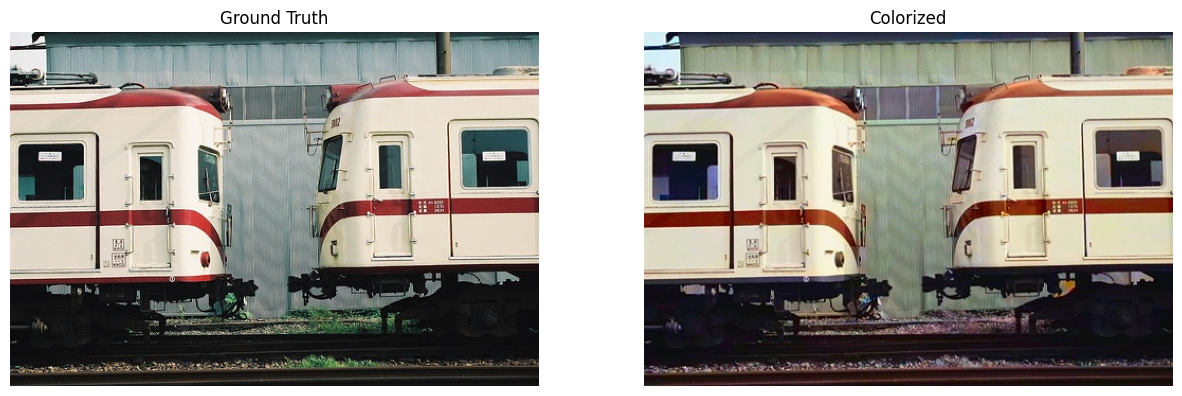

In [106]:
def single_colorization_visualization(model, image, seed=0, num_inference_steps=10, generate_caption=True, positive_prompt="",
                                      negative_prompt="low quality, bad quality, low contrast, black and white, bw, monochrome, grainy, blurry, historical, restored, desaturate"):

    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(5*3, 5))
    if isinstance(image, str):
        image = PIL.Image.open(image)
        size = image.size
        caption = None
    elif isinstance(image, dict):
        image, caption, size = transforms.ToPILImage()(image["image"]), image["caption"], image["size"]
    elif isinstance(image, torch.Tensor):
        image = transforms.ToPILImage()(data[idx]["image"])
        size = image.size
    
    colored, caption = colorize_single_image(image=image, pipe=model, caption=caption, size=size, num_inference_steps=num_inference_steps,
                                    positive_prompt=positive_prompt, negative_prompt=negative_prompt, seed=seed, generate_caption=generate_caption)

    if generate_caption:
        print("Caption:", caption)
        
    ax[0].imshow(image.resize(size))
    ax[0].axis("off")
    ax[0].set_title("Ground Truth")
    # ax[1].imshow(image.convert("L").resize(size), cmap="gray")
    # ax[1].axis("off")
    # ax[1].set_title("Grayscale")
    ax[1].imshow(colored)
    ax[1].axis("off")
    ax[1].set_title("Colorized")
    # plt.tight_layout()

image = "/kaggle/input/pascal-voc-2012/VOC2012/JPEGImages/2007_000042.jpg"
single_colorization_visualization(pipe, image, seed=123, num_inference_steps=20, positive_prompt="", generate_caption=True)

In [84]:
def multi_colorization_visualization(model, data, index, vertical=True, seed=0):
    if vertical:
        nrows = len(index)
        fig, axes = plt.subplots(ncols=3, nrows=nrows, figsize=(5*3, 5*nrows))
        for ax, idx in zip(axes, index):
            image, caption, size = transforms.ToPILImage()(data[idx]["image"]), data[idx]["caption"], data[idx]["size"]
            colored, caption = colorize_single_image(image=image, pipe=model, caption=caption, size=size, seed=seed)
            ax[0].imshow(image.resize(size))
            ax[0].axis("off")
            ax[0].set_title("Ground Truth")
            ax[1].imshow(image.convert("L").resize(size), cmap="gray")
            ax[1].axis("off")
            ax[1].set_title("Grayscale")
            ax[2].imshow(colored)
            ax[2].axis("off")
            ax[2].set_title("Colorized")
            
    else:
        ncols = len(index)
        fig, axes = plt.subplots(ncols=ncols, nrows=2, figsize=(5*ncols, 10))
        for ax, idx in enumerate(index):
            image, caption, size = transforms.ToPILImage()(data[idx]["image"]), data[idx]["caption"], data[idx]["size"]
            colored, caption = colorize_single_image(image=image, pipe=model, caption=caption, size=size, seed=seed)
            axes[0][ax].imshow(image.resize(size))
            axes[0][ax].axis("off")
            axes[0][ax].set_title("Ground Truth")
            axes[1][ax].imshow(colored)
            axes[1][ax].axis("off")
            axes[1][ax].set_title("Colorized")

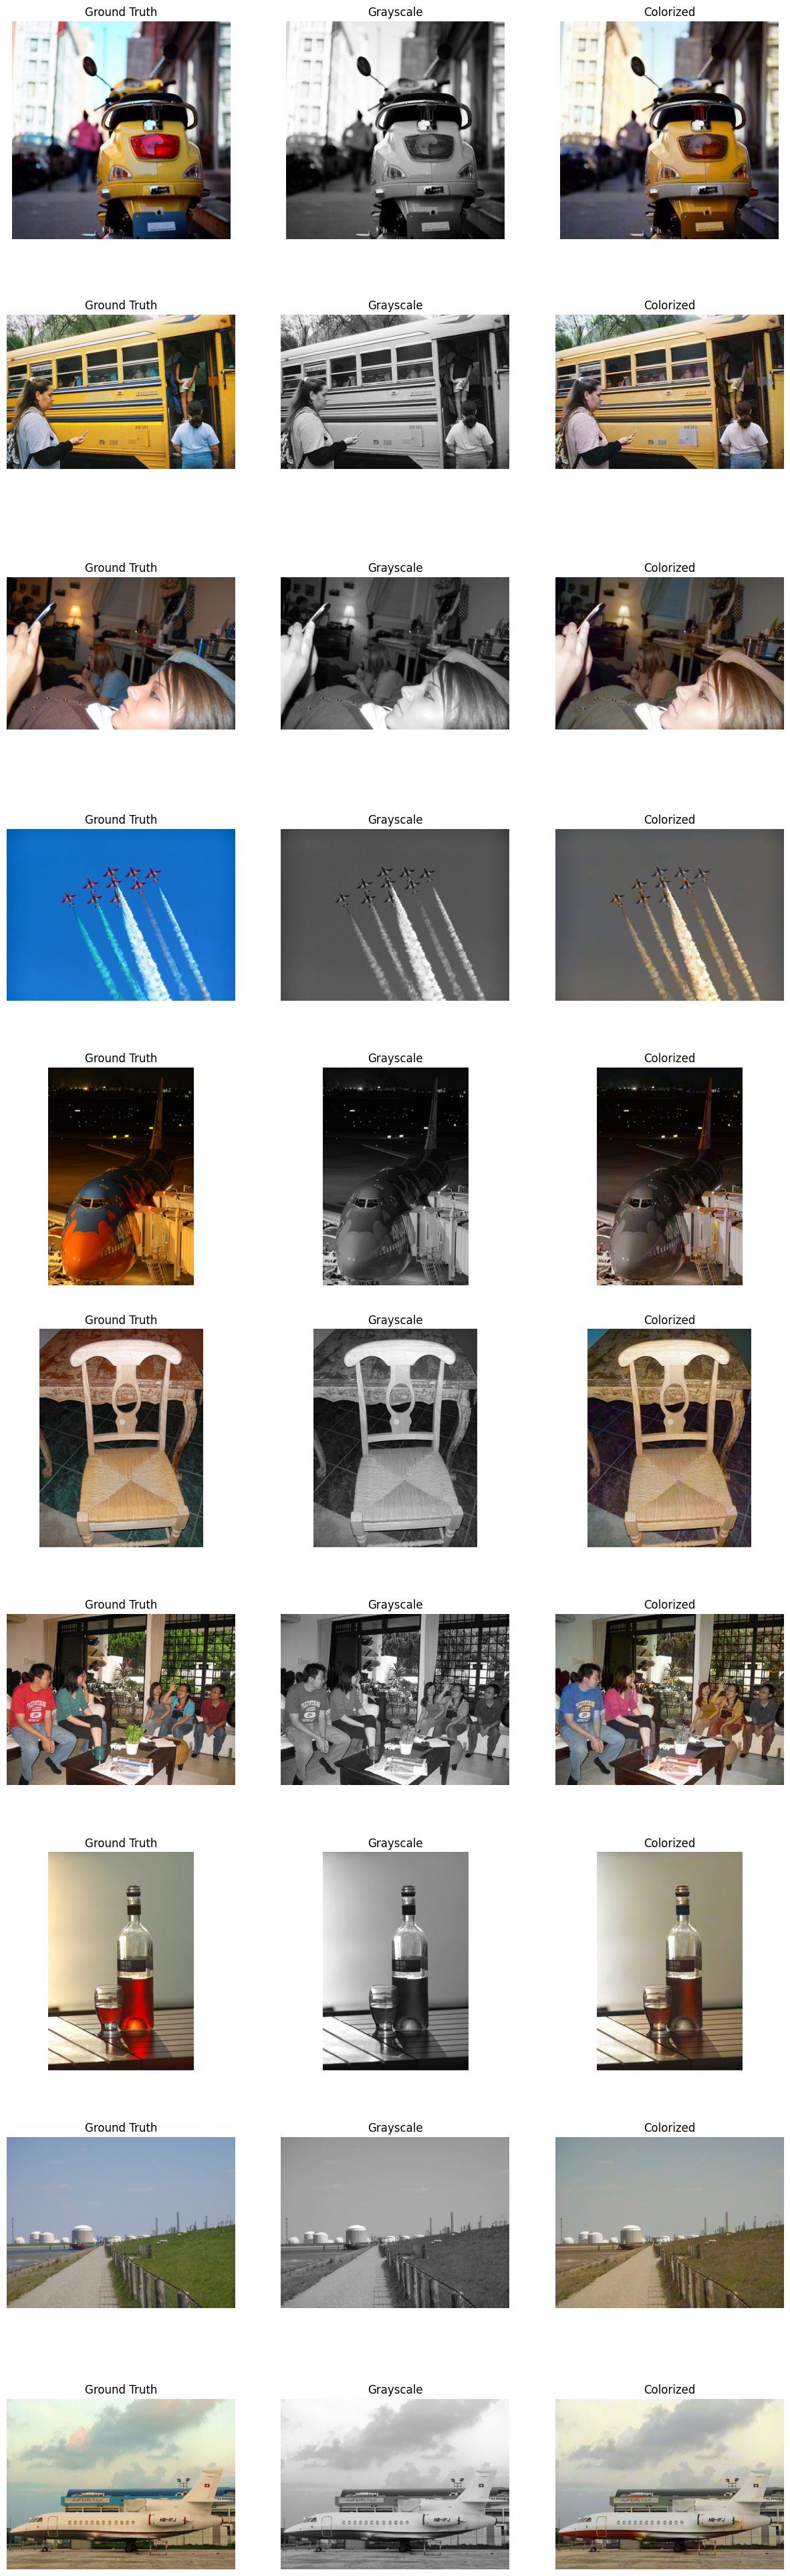

In [94]:
multi_colorization_visualization(pipe, val_set, range(0, 10), seed=123)

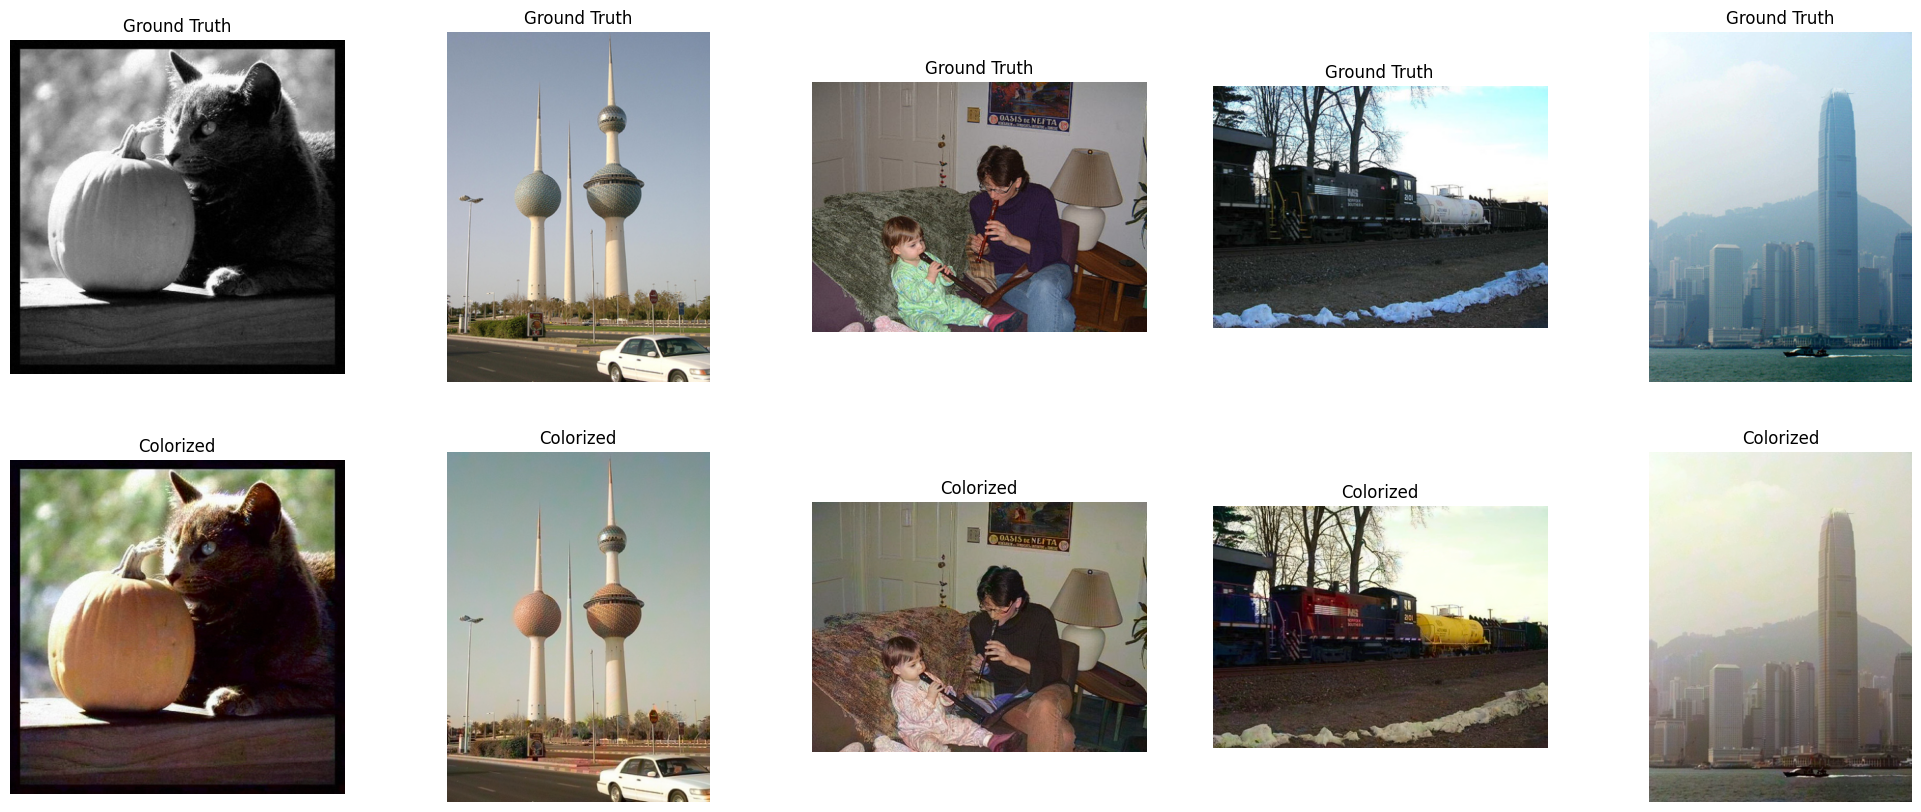

In [93]:
general_test_paths = collect_paths("/kaggle/input/colorization-validation")
general_test = ColorizationDataset(image_paths=general_test_paths, device=accelerator.device, set=None, transform=transform, caption_processor=blip_processor, caption_generator=blip_generator)
multi_colorization_visualization(pipe, general_test, range(len(general_test)), vertical=False, seed=123)